In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from torchvision import transforms
from tensorboardX import SummaryWriter
from torch.autograd import Variable
from tqdm import tqdm
from model import *

import util.loader.transform as tr
from util.loader.loader import DAVIS2016
from util.metrics import runningScore
from util.loss import *
from util.utils import *
from util.helpers import *

from PIL import Image
from matplotlib import pyplot as plt

In [2]:
img_rows   = 256
img_cols   = 512
batch_size = 1

vtransforms = transforms.Compose([tr.Resize([img_rows, img_cols]), tr.ToTensor()])
vdataset = DAVIS2016(root='../dataset/davis.pkl', split='val', transform=vtransforms)
vdataloader = torch.utils.data.DataLoader(vdataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [3]:
# Setup Metrics
running_metrics = runningScore(pspnet_specs['n_classes'])

# setup Model
base_net = BaseNet()
motion_net = MotionNet()
class_net = ClassNet()

base_net.load_state_dict(torch.load('weight/base_net.pkl'))
motion_net.load_state_dict(torch.load('weight/motion_net.pkl'))
class_net.load_state_dict(torch.load('weight/class_net.pkl'))

base_net.cuda()
motion_net.cuda()
class_net.cuda()

pspnet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

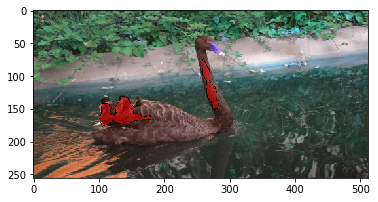

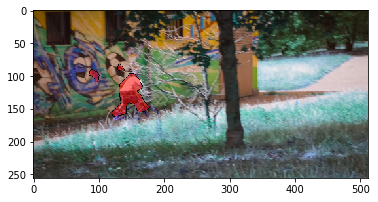

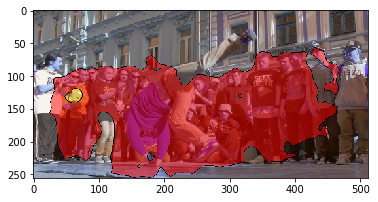

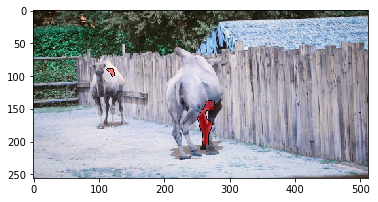

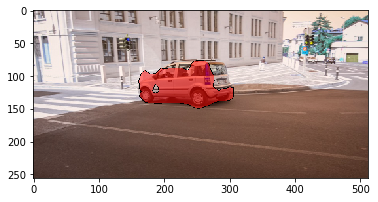

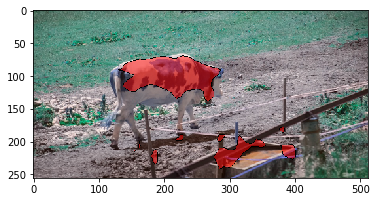

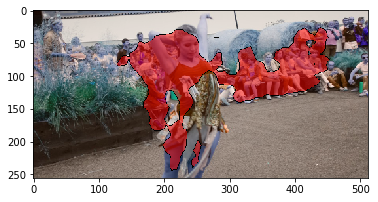

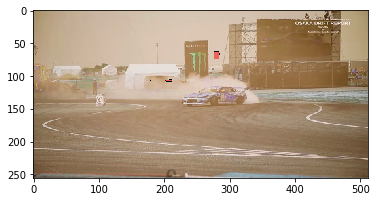

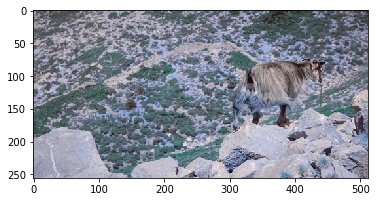

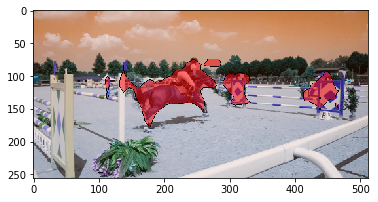

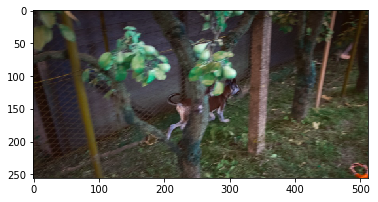

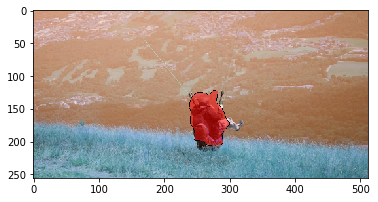

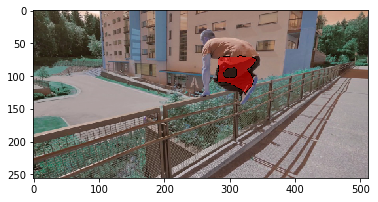

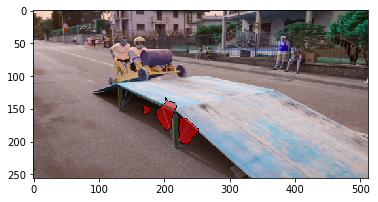

('FreqW Acc : \t', 0.8447452913537775)
('Overall Acc: \t', 0.901588058195052)
('Mean Acc : \t', 0.6682850376719127)
('Mean IoU : \t', 0.5716425604320454)


In [7]:
import time
base_net.eval()
motion_net.eval()
class_net.eval()
for i, (data1, data2, data3) in enumerate(tdataloader):
    images1 = Variable(data1['image'].cuda())
    images2 = Variable(data2['image'].cuda())
    images3 = Variable(data3['image'].cuda())
    labels  = Variable(data3['gt'].type(torch.LongTensor).cuda())

    seg, inp = base_net(images3)
    motion = motion_net(images1, images2, images3)
    outputs = class_net(motion, seg, inp)

    mask = outputs.data.max(1)[1].cpu()
    pred = mask.numpy()
    gt = labels.data.cpu().numpy()
    running_metrics.update(gt, pred)
    if i % 100 == 0:
        plt.imshow(overlay_mask(im_normalize(tens2image(data3['image'])), tens2image(mask)))
        plt.show()
        time.sleep(1)
score, class_iou = running_metrics.get_scores()
for k, v in score.items():
    print(k, v)